## \# Import packages

In [1]:
import os
import cv2
import glob
import random

import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from scipy import ndimage

import matplotlib.pyplot as plt
import matplotlib.animation as ani
import matplotlib.patches as patches

## \# Process Data

In [2]:
def process_excel_data(fname_excel: str = None, 
                       fname_csv: str = None) -> pd.DataFrame:
    ''''
    Convert Excel data to CSV data to work with DigitalGuardRails pipeline; saves CSV data.

    Parameters:
    fname_excel (str): path to Excel file (created by TekScan software)
    fname_csv   (str): path to save CSV file

    Returns:
    df_processed_data: pandas dataframe of shape = <num_frames, 1024>

    '''

    # Check if input file from TekScan exists.
    if not os.path.exists(fname_excel):
        raise ValueError('{} does not exist.'.format(fname_excel))

    # Check if output file already exists.
    if os.path.exists(fname_csv):
        print('Processed CSV data already exists; loading data...')
        df_processed_data = pd.read_csv(fname_csv, index_col=0)
    
    else:
        print('Processing Excel data...')
        df_raw_data = pd.read_excel(fname_excel).T
        df_processed_data = df_raw_data[df_raw_data.columns[-1024:]].iloc[1:].reset_index().drop('index', axis=1)
        print('Saving processed CSV data to: {}'.format(fname_csv))
        df_processed_data.to_csv(fname_csv)
    
    print('Found {} frames.'.format(df_processed_data.shape[0]))
    print('Done.')
    
    return df_processed_data

In [3]:
fname_excel = '../GM_NICU_Excel/pt 021.xlsx'
fname_csv = './test_output.csv'

In [4]:
df_data = process_excel_data(fname_excel=fname_excel, 
                             fname_csv=fname_csv)

Processed CSV data already exists; loading data...
Found 6313 frames.
Done.


## \# Visualize Data

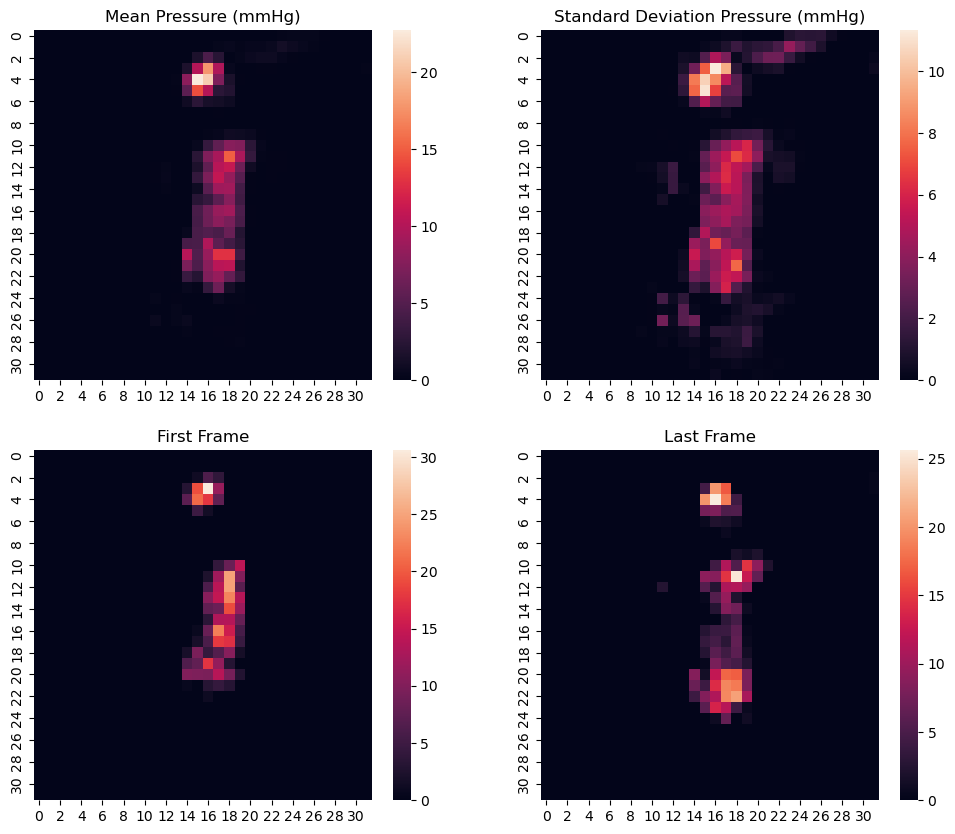

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12,10), facecolor='white')
sns.heatmap( np.reshape( df_data.mean(),   (32,32) ), cbar=True, ax=axes[0][0] )
sns.heatmap( np.reshape( df_data.std(),    (32,32) ), cbar=True, ax=axes[0][1] )
sns.heatmap( np.reshape( df_data.iloc[0],  (32,32) ), cbar=True, ax=axes[1][0] )
sns.heatmap( np.reshape( df_data.iloc[-1], (32,32) ), cbar=True, ax=axes[1][1] )

for i, title in enumerate( ['Mean Pressure (mmHg)',
                            'Standard Deviation Pressure (mmHg)',
                            'First Frame', 
                            'Last Frame'] ):
    axes[int(i/2)][int(i%2)].title.set_text(title)

plt.show()

## \# Generate Frame-by-Frame Measurement Data

In [6]:
def get_fnum2stats(df_data: pd.DataFrame, 
                   artificial_shift: bool = False, 
                   shift_frequency: int = 10,
                   dangerzone_width: int = 5) -> {}:
    '''
    Convert df_data to dictionary on frame-by-frame basis.

    Parameters:
    df_data      (pd.DataFrame): pandas dataframe of processed (CSV) data with pressure data
    artificial_shift     (bool): True to apply artificial shift to data, False to show data as collected
    shift_frequency       (int): number of increments when applying artificial shift
    dangerzone_width      (int): number of cells from the edge to be considered ``in danger''

    Returns:
    fnum2stats: dictionary with keys = frame numbers, values = {} of measurements

    '''

    print('Artificial shift: {}'.format(artificial_shift))
    
    fnum2stats = {}
    for fnum, row in df_data.iterrows():
    
        # reshape (1024,) floats to (32,32)
        arr_pressure = np.reshape( np.asarray( [float(e) for e in row.values] ), (32,32) )

        if artificial_shift:
            shift = int( (fnum/len(df_data)) * shift_frequency )  # determine shift value based on current frame and shift_frequency
            if shift > 0:
                arr_pressure = np.roll(arr_pressure, shift, axis=1) # shift array column-wise to the right
                arr_pressure[:, :shift] = 0 # zero out rest of column (avoid wrap-around)

        # get pressure array and corresponding masked array
        pressureCond = (arr_pressure > 0) & (arr_pressure < 200) # get rid of cells registering 200 since likely error
        arr_mask = (pressureCond).astype(np.uint8) # either 0 or 1
        arr_s = np.where(pressureCond, arr_pressure, 0) # either <pressure> or 0, depending on mask
                        
        # get center of pressure for arr_s
        (CoP_y_entire, CoP_x_entire) = ndimage.center_of_mass( arr_s[ : , : ] )

        # get distance between CoP and edge of mat, assign color based on distance
        dist2edge = min(31 - CoP_x_entire, 31 - CoP_y_entire)
        if dist2edge > dangerzone_width * 2:
            col_index = 0
        elif dist2edge > dangerzone_width:
            col_index = 1
        else:
            col_index = 2
            
        fnum2stats[fnum] = {
            'arr_s': arr_s ,
            'arr_mask': arr_mask ,
            'CoP_entire': [ CoP_x_entire, CoP_y_entire ] ,
            'CoP_entire_ani': [ [ CoP_x_entire ], [ CoP_y_entire ] ] , # same data, diff format for animation purposes
            'col_index': col_index
        }

    print('Calculated measurements for {} frames.'.format(len(fnum2stats)))

    return fnum2stats

In [7]:
dangerzone_width = 5
artificial_shift = True
shift_frequency = 16

In [8]:
fnum2stats = get_fnum2stats(df_data, 
                            artificial_shift=artificial_shift, 
                            shift_frequency=shift_frequency,
                            dangerzone_width=dangerzone_width)

Artificial shift: True
Calculated measurements for 6313 frames.


In [9]:
fnum2stats[0]

{'arr_s': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'arr_mask': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'CoP_entire': [16.931380143071944, 12.805075864582863],
 'CoP_entire_ani': [[16.931380143071944], [12.805075864582863]],
 'col_index': 0}

### \# Set Up Grid Parameters

In [10]:
xs = range(0, 32)
ys = range(0, 32)

In [11]:
x, y = np.meshgrid(xs, ys)

In [12]:
x_flat = x.flatten()
y_flat = y.flatten()

In [13]:
colors = [
    ['#ECFDF3','#17B26A'], # safe/middle of grid - col_index = 0
    ['#FFFAEB', '#F79009'], # moving toward edge - col_index = 1
    ['#FEF3F2', '#F04438'], # unsafe/edge of grid - col_index = 2
]

### \# Set Up Animation Parameters

In [14]:
fps_in = 30 # Acc. to default settings for TekScan recording software
fps_out = 15 # Acc. to desired frame rate for output .mp4 (less fps_out means faster animation)

### \# Generate Animation

In [15]:
def render_and_save_animation(fnum2stats: dict,
                              fname_ani: str,
                              fps_in: int = 30,
                              fps_out: int = 10):
    '''
    Generate animation video from frame-by-frame measurements.

    Parameters:
    fnum2stats   (dict): dictionary to translate frame number to array and CoP data (with colors)
    fps_in        (int): frame rate for raw data collection (default=30) 
    fps_out       (int): frame rate for output animation 
    fname_ani     (str): path to save animation
    
    '''

    # Calculate how often to skip frames to get desired frame rate for output .mp4.
    if fps_in % fps_out > 0:
        skip = 1
    else:
        skip = int(fps_in/fps_out)
    print('Skipping every {}th frame...'.format(skip))
    
    # Set up general animation parameters
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    
    plt.xticks([i for i in range(32)], [''] * 32)
    plt.yticks([i for i in range(32)], [''] * 32)
    
    ax.tick_params('both', length=5, width=1, which='major')
    
    # plt.grid()
    plt.gca().invert_yaxis()
    ax.spines[['top','left','bottom','right']].set_linewidth(3)
    
    # Set up initial conditions of pressure and center of pressure (CoP)
    ax.set_facecolor(colors[fnum2stats[0]['col_index']][0])
    
    pressure_ax = ax.scatter(
        x_flat,
        y_flat,
        s=fnum2stats[0]['arr_s'].flatten(),
        c=colors[fnum2stats[0]['col_index']][1],
        marker='o',
    )
    
    CoP_body_ax, = ax.plot(
        fnum2stats[0]['CoP_entire_ani'],
        c=colors[fnum2stats[0]['col_index']][1],
        marker = 'x',
        markersize = 25
    )
    
    # Function to update the plot
    def update(fnum):
    
        c_mat, c_points = colors[fnum2stats[fnum]['col_index']][:] # get colors of mat and points from fnum2stats based on fnum
    
        ax.set_facecolor( c_mat ) # update color of mat/background
        
        pressure_ax.set_sizes( fnum2stats[fnum]['arr_s'].flatten() ) # update pressure data
        pressure_ax.set_color( c_points ) # update color of points/pressure data (all points)
        
        CoP_body_ax.set_data( fnum2stats[fnum]['CoP_entire_ani'][:] ) # update center of pressure data based on fnum
        CoP_body_ax.set_color( c_points ) # update color of points/pressure data (CoP)
            
        return pressure_ax, CoP_body_ax, # return list of artists
    
    # Render animation
    animation = ani.FuncAnimation(fig, update,
                                  frames=[x for x in range(0, len(fnum2stats), skip)], # skip every "skip"-th frame
                                  interval=int(1000/(fps_out)), # control frame rate of output animation
                                  blit=True) 
    
    # Save the animation
    print('Saving animation to {}...'.format(fname_ani))
    animation.save(fname_ani)
    print('Done.')

In [16]:
fname_ani = './test_animation.mp4'

Skipping every 2th frame...
Saving animation to ./test_animation.mp4...
Done.


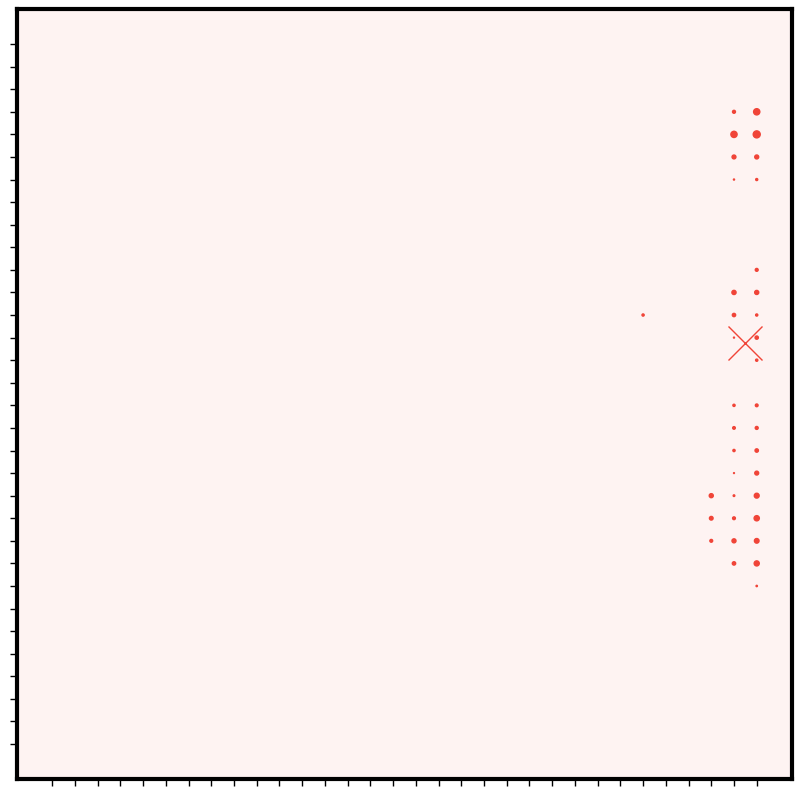

In [17]:
render_and_save_animation(fnum2stats, 
                          fname_ani=fname_ani, 
                          fps_in=fps_in, 
                          fps_out=fps_out)